In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
import seaborn as sns
from scipy import ndimage
import io
import xarray as xr
import pickle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factor_small.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
shearSE = fshear['SE']
tcwvfac_all =  ftcw['abs'] 

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

cp4_precip_hist = ftcw['prcp_hist']

ltag = 'sahel'

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
tcwvfac_all

array([1.19938758, 1.19938758, 1.104523  , 1.17877165, 1.17111967,
       1.15693016, 1.08019338, 1.16968217, 1.09620372, 1.28048504,
       1.18748565, 1.22224398, 1.19137074, 1.24554717, 1.22338062,
       1.23320867, 1.31619694, 1.2043598 , 1.32834691, 1.20466736])

In [5]:
shearfac

0.7762568058787446

In [6]:
shearSE

0.14696280270955595

In [7]:
np.mean(tcwvfac_all)

1.1996745900023602

In [8]:
print(fshear.keys())
print(ftcw.keys())

dict_keys(['obs_shear', 'cp4_shear', 'SE'])
dict_keys(['rel', 'abs', 'tcw_hist', 'prcp_hist', 'tcw_fut', 'prcp_fut'])


In [9]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_read = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY.csv', index_col=0)

    cp4_read['period'].append(dd)
    cp4_read['shear'].append(np.array(dic.loc['shear']))
    cp4_read['tcwv'].append(np.array(dic.loc['tcwv']))


In [10]:
cp4_read

{'period': ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut'],
 'shear': [array([14.837187]),
  array([17.849745]),
  array([15.060823]),
  array([16.72843])],
 'tcwv': [array([41.307987]),
  array([62.077488]),
  array([41.892784]),
  array([63.646557])]}

In [11]:
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')

In [12]:
cp4_df.loc['CP25fut','shear']

array([16.72843])

In [13]:
cp4_df.loc['CP25hist','shear']

array([15.060823])

In [14]:
cp4_shear_diff = (cp4_df.loc['CP4fut', 'shear']-cp4_df.loc['CP4hist', 'shear'])#/cp4_df.loc['CP4hist', 'shear']*100
cp25_shear_diff = (cp4_df.loc['CP25fut', 'shear']-cp4_df.loc['CP25hist', 'shear'])#/cp4_df.loc['CP25hist', 'shear']*100

cp4_tcwv_diff = (cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv'])/cp4_df.loc['CP4hist', 'tcwv']
cp25_tcwv_diff = (cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv'])/cp4_df.loc['CP25hist', 'tcwv']

cp4_tcwv_abs = (cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv'])
cp25_tcwv_abs = (cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv'])

cp4_historical_domainMean = cp4_df.loc['CP4hist', 'tcwv']
cp4_future_domainMean = cp4_df.loc['CP4fut', 'tcwv']

cp25_historical_domainMean = cp4_df.loc['CP25hist', 'tcwv']
cp25_future_domainMean = cp4_df.loc['CP25fut', 'tcwv']

In [15]:
ftcw['tcw_fut']-ftcw['tcw_hist']

array([12.57, 16.05, 17.11, 17.79, 18.27, 18.58, 18.8 , 19.  , 19.21,
       19.41, 19.63, 19.89, 20.12, 20.34, 20.57, 20.81, 21.09, 21.43,
       21.87, 23.85])

In [16]:
cp4_df.loc['CP4hist', 'tcwv']

array([41.307987])

In [17]:
cp4_df.loc['CP4fut', 'tcwv']

array([62.077488])

In [18]:
(ftcw['tcw_fut']-ftcw['tcw_hist'])/ftcw['tcw_hist']

array([0.4466951 , 0.4593589 , 0.46431479, 0.46582875, 0.46524064,
       0.46172962, 0.45742092, 0.45367717, 0.45083314, 0.44837145,
       0.44674556, 0.44636445, 0.44513274, 0.4436205 , 0.44217541,
       0.44033009, 0.43864393, 0.43681207, 0.43358446, 0.41550523])

In [19]:
cp4_tcwv_abs

array([20.769501])

In [20]:
cp4_tcwv_diff

array([0.50279625])

In [21]:
print(cp4_df.loc['CP4hist', 'tcwv'], ftcw['tcw_hist'])

[41.307987] [28.14 34.94 36.85 38.19 39.27 40.24 41.1  41.88 42.61 43.29 43.94 44.56
 45.2  45.85 46.52 47.26 48.08 49.06 50.44 57.4 ]


In [22]:
print(cp4_df.loc['CP4fut', 'tcwv'], ftcw['tcw_fut'])

[62.077488] [40.71 50.99 53.96 55.98 57.54 58.82 59.9  60.88 61.82 62.7  63.57 64.45
 65.32 66.19 67.09 68.07 69.17 70.49 72.31 81.25]


In [23]:
cp4_historical_domainMean

array([41.307987])

In [24]:
cp4_future_domainMean-cp4_historical_domainMean

array([20.769501])

In [25]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip5_read = {}
cmip_read = {}
for dd in dics:
    cmip5_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP_'+ltag+'.csv', index_col='model_name')

#     (cmip_read[dd[1]])['shear_mean_precip'] = (cmip_read[dd[1]])['shear_mean'] 
#     (cmip_read[dd[1]])['tcw_mean_precip'] = (cmip_read[dd[1]])['tcwv_mean'] 
#     (cmip_read[dd[1]])['shear_perc_'] = (cmip_read[dd[1]])['tcwv_mean'] 

In [26]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip6_read = {}
for dd in dics:
    cmip6_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP6_'+ltag+'.csv', index_col='model_name')
    
#     (cmip_read[dd[1]])['shear_mean_precip'] = (cmip_read[dd[1]])['shear_mean'] 
#     (cmip_read[dd[1]])['tcw_mean_precip'] = (cmip_read[dd[1]])['tcwv_mean'] 
#     (cmip_read[dd[1]])['shear_perc_'] = (cmip_read[dd[1]])['tcwv_mean'] 

In [27]:
for dd in dics:
    cmip_read[dd[1]] = pd.concat([cmip5_read[dd[1]], cmip6_read[dd[1]]])
    cmip_read[dd[1]] = cmip_read[dd[1]].dropna()

In [28]:
cmip_read

{'2030':                Unnamed: 0  shear_mean  tcw_mean   tcw_hist  shear_hist
 model_name                                                            
 CESM1-BGC               0    0.243406  4.838860  38.777592   13.507772
 inmcm4                  1    0.548253  2.302975  36.695497   15.766823
 FGOALS-g2               2    0.287669  4.396065  37.412062   15.849583
 MIROC-ESM               3    1.417241  8.929013  36.005216   12.069769
 CMCC-CM                 4    1.041465  6.312541  41.365444   12.191259
 ...                   ...         ...       ...        ...         ...
 CNRM-CM6-1-HR          22    1.011095  5.977420  35.403252   10.980959
 FGOALS-g3              23    0.447257  3.984820  35.509907   14.927516
 UKESM1-0-LL            24    2.339993  9.827964  32.762188    9.996843
 ACCESS-CM2             25    1.700484  8.520968  32.308384    7.154656
 INM-CM4-8              26    1.220269  4.913383  39.112930   15.213412
 
 [64 rows x 5 columns],
 '2040':                Unname

In [29]:
colours = np.array(['k']*len(cmip5_read['2030']) + ['r']*len(cmip6_read['2030']))

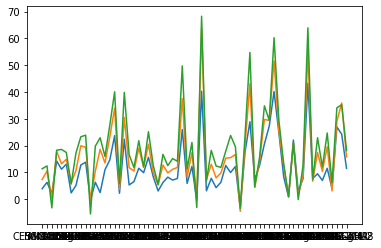

In [30]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['shear_mean']/((cmip_read[y])['shear_hist'])*100)

18.78421590949344
28.298493924829387
39.518142198988805


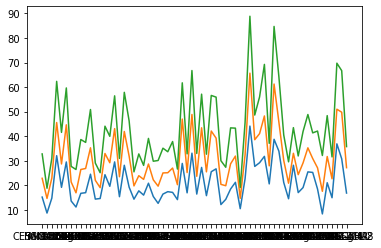

In [31]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist'])*100)
    #print(np.max(cmip6_read[y]['tcw_mean']/((cmip6_read[y])['tcw_hist'])*100))
    print(np.nanmedian(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist'])*100))

7.262661933898926
10.899810607610782
15.129162052826498


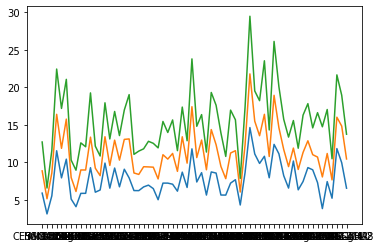

In [32]:
for y in ['2040','2060', '2080']:
    plt.plot((cmip_read[y]['tcw_mean']+(cmip_read[y])['tcw_hist'])-((cmip_read[y])['tcw_hist']))
    print(np.nanmedian((cmip_read[y]['tcw_mean']+(cmip_read[y])['tcw_hist'])-((cmip_read[y])['tcw_hist'])))

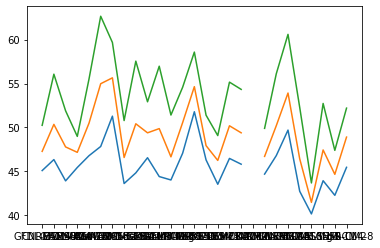

In [33]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip6_read[y]['tcw_mean']+((cmip6_read[y])['tcw_hist']))

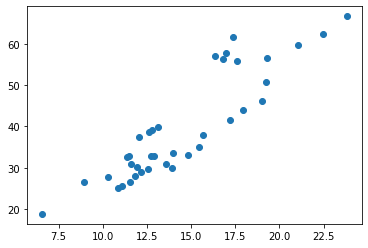

In [34]:
y='2080'
plt.scatter(cmip5_read[y]['tcw_mean'], cmip5_read[y]['tcw_mean']/((cmip5_read[y])['tcw_hist'])*100)

In [35]:
cmip6_read['2030'].index

Index(['GFDL-ESM4', 'CNRM-CM6-1', 'GFDL-CM4', 'CAMS-CSM1-0', 'CESM2-WACCM',
       'CanESM5', 'AWI-CM-1-1-MR', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR',
       'NorESM2-MM', 'EC-Earth3-Veg', 'HadGEM3-GC31-LL', 'MIROC-ES2L',
       'MIROC6', 'MRI-ESM2-0', 'BCC-CSM2-MR', 'MPI-ESM1-2-HR', 'NorESM2-LM',
       'CMCC-CM2-SR5', 'KACE-1-0-G', 'CNRM-ESM2-1', 'CIESM', 'CNRM-CM6-1-HR',
       'FGOALS-g3', 'UKESM1-0-LL', 'ACCESS-CM2', 'INM-CM4-8'],
      dtype='object', name='model_name')

In [36]:
cmip5_read['2030'].index

Index(['CESM1-BGC', 'inmcm4', 'FGOALS-g2', 'MIROC-ESM', 'CMCC-CM', 'GFDL-CM3',
       'bcc-csm1-1', 'FIO-ESM', 'MRI-ESM1', 'MRI-CGCM3', 'BNU-ESM',
       'GFDL-ESM2G', 'GFDL-ESM2M', 'CanESM2', 'NorESM1-M', 'HadGEM2-ES',
       'CESM1-CAM5', 'ACCESS1-0', 'CMCC-CMS', 'GISS-E2-R', 'IPSL-CM5B-LR',
       'GISS-E2-H-CC', 'NorESM1-ME', 'GISS-E2-H', 'CNRM-CM5', 'CMCC-CESM',
       'MPI-ESM-LR', 'MPI-ESM-MR', 'GISS-E2-R-CC', 'HadGEM2-CC', 'CCSM4',
       'MIROC-ESM-CHEM', 'MIROC5', 'ACCESS1-3', 'bcc-csm1-1-m', 'IPSL-CM5A-MR',
       'IPSL-CM5A-LR', 'CSIRO-Mk3-6-0'],
      dtype='object', name='model_name')

LinregressResult(slope=-2.9994801107858033, intercept=157.42977969695454, rvalue=-0.730958885068343, pvalue=2.2238611514273124e-05, stderr=0.5716103967884698)


Text(0.5, 0, 'Absolute TCW change (mm)')

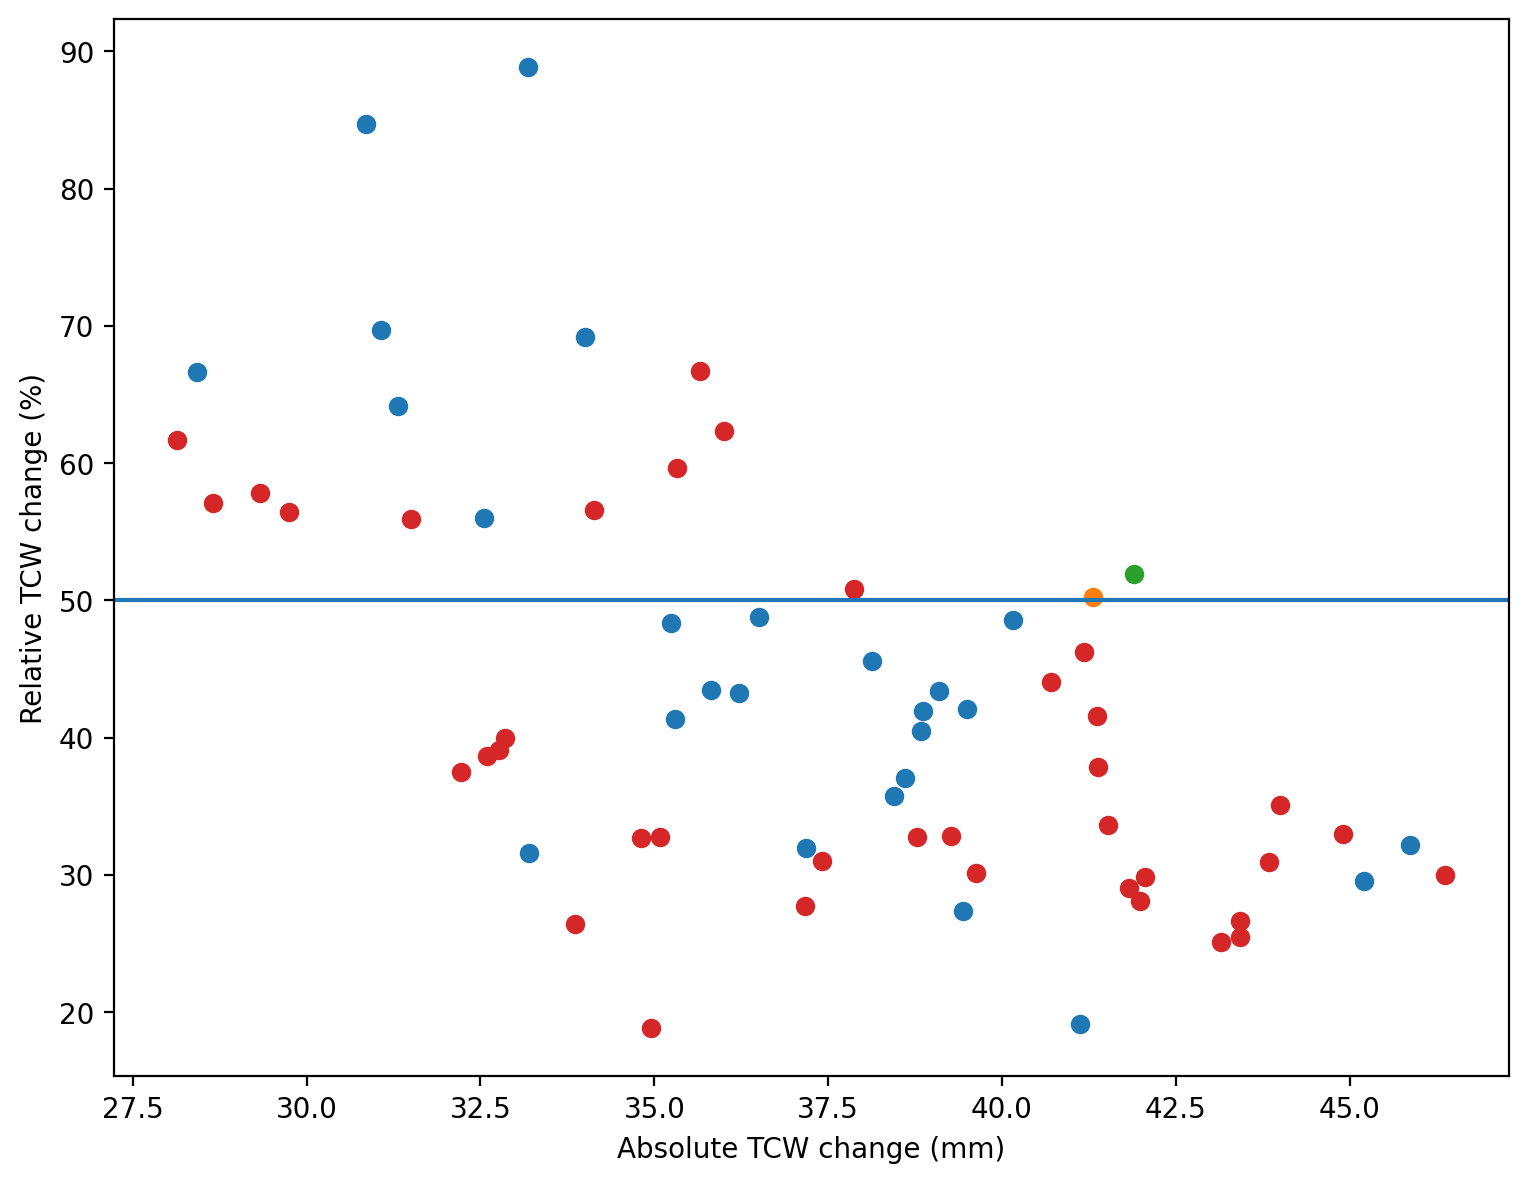

In [37]:
yy='2080'
f = plt.figure(figsize=(9,7), dpi=200)

x = cmip6_read[yy]['tcw_hist']
x = x[np.isfinite(x)]
y = (cmip6_read[yy]['tcw_mean']/((cmip6_read[yy])['tcw_hist'])*100)
y = y[np.isfinite(y)]



plt.scatter(x, y)
print(stats.linregress(x, y  ))
plt.scatter(cp4_historical_domainMean, cp4_tcwv_diff*100)
plt.scatter(cp25_historical_domainMean, cp25_tcwv_diff*100)

plt.scatter(cmip5_read[yy]['tcw_hist'], cmip5_read[yy]['tcw_mean']/((cmip5_read[yy])['tcw_hist'])*100)
plt.axhline(50)
plt.ylabel('Relative TCW change (%)')
plt.xlabel('Absolute TCW change (mm)')

LinregressResult(slope=3.28452922625296, intercept=-8.069934450650521, rvalue=0.9358806152427303, pvalue=8.744228464179622e-30, stderr=0.157032951244864)
LinregressResult(slope=-2.9994801107858033, intercept=157.42977969695454, rvalue=-0.730958885068343, pvalue=2.2238611514273124e-05, stderr=0.5716103967884698)
LinregressResult(slope=-0.6058831969212742, intercept=39.099898306353616, rvalue=-0.5381182589933644, pvalue=0.004573002770785566, stderr=0.19371614591345063)


Text(0, 0.5, 'Absolute TCW change (mm)')

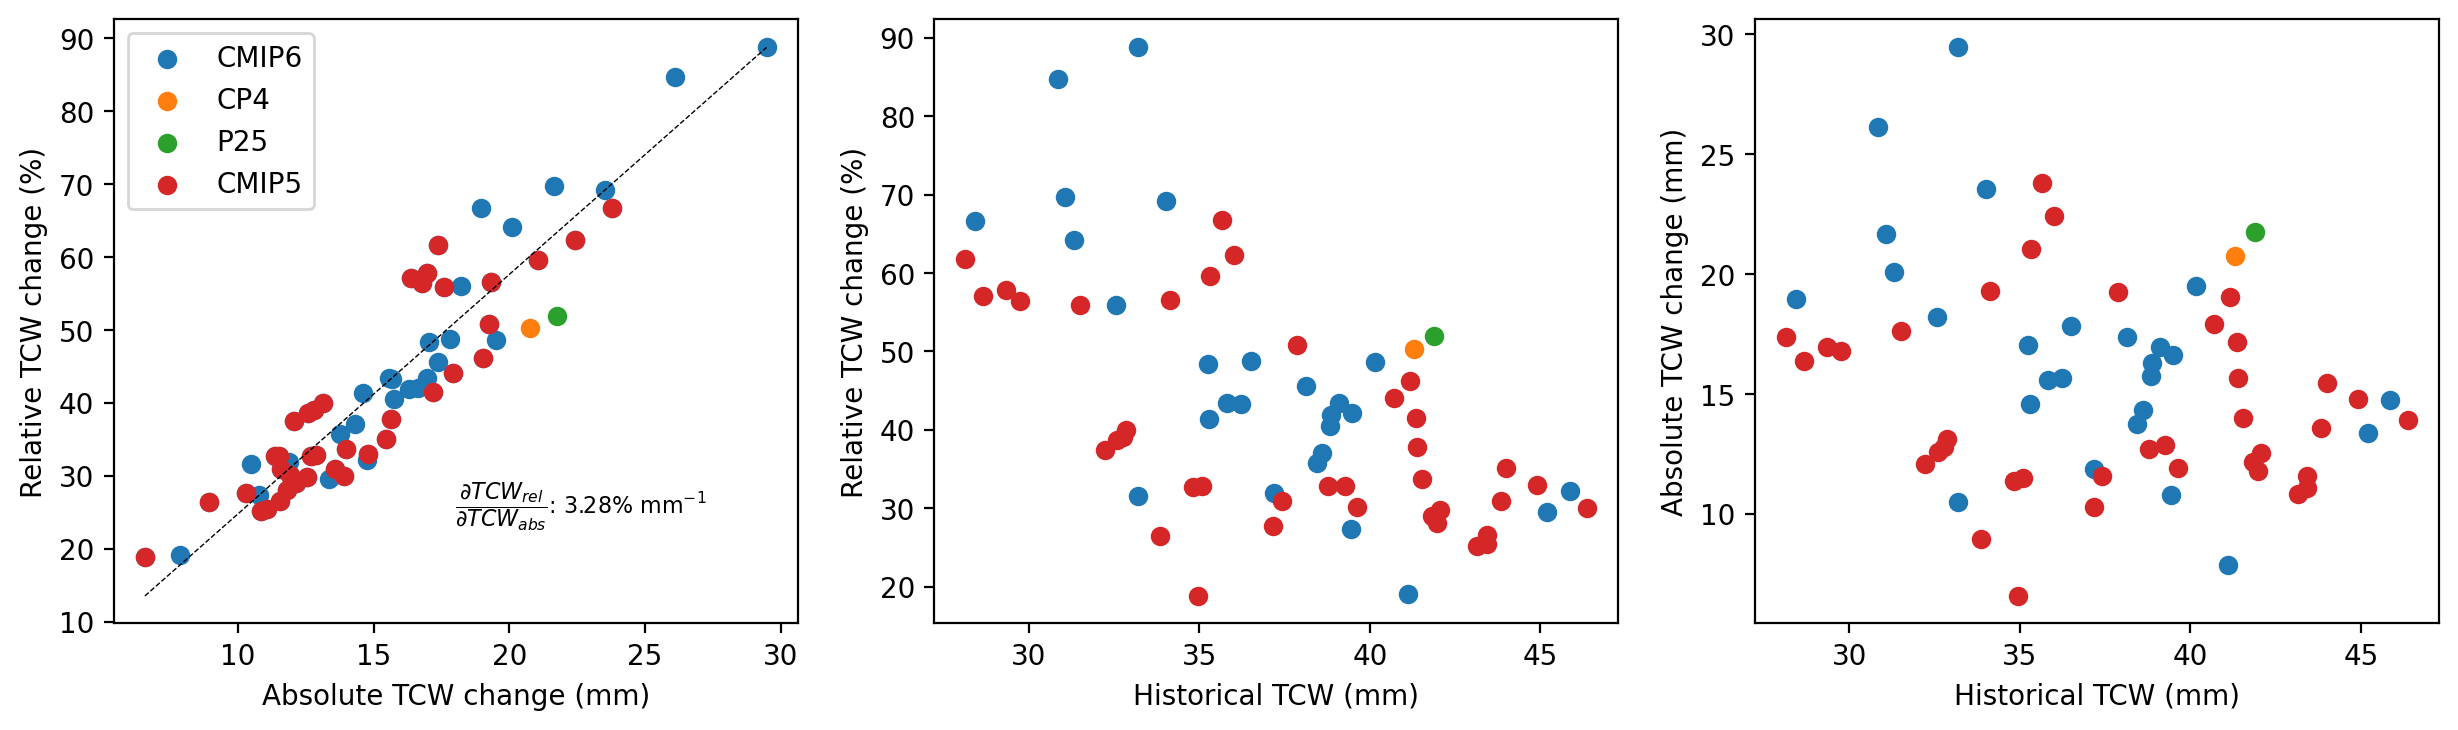

In [38]:
yy='2080'
f = plt.figure(figsize=(15,4), dpi=200)
ax = f.add_subplot(131)

x = cmip_read[yy]['tcw_mean']
x = x[np.isfinite(x)]
y = (cmip_read[yy]['tcw_mean']/((cmip_read[yy])['tcw_hist'])*100)
y = y[np.isfinite(y)]



plt.scatter(x, y, label='CMIP6')
print(stats.linregress(x, y  ))
cslope, sintercept, cr, cpval, cstd = stats.linregress(x, y  )
plt.scatter(cp4_tcwv_diff*cp4_historical_domainMean, cp4_tcwv_diff*100, label='CP4')
plt.scatter(cp25_tcwv_diff*cp25_historical_domainMean, cp25_tcwv_diff*100, label='P25')

plt.plot(np.linspace(np.min(x), np.max(x),10), sintercept + cslope * np.linspace(np.min(x), np.max(x),10), linestyle='dashed', linewidth=0.5, color='k')
plt.text(18,25, r'$\dfrac{\partial TCW_{rel}}{\partial TCW_{abs}}$: ' + str(np.round(cslope,2)) +r'% mm$^{-1}$', fontsize=8)

plt.scatter(cmip5_read[yy]['tcw_mean'], cmip5_read[yy]['tcw_mean']/((cmip5_read[yy])['tcw_hist'])*100,  label='CMIP5')
#plt.axhline(50)
plt.ylabel('Relative TCW change (%)')
plt.xlabel('Absolute TCW change (mm)')
plt.legend()

ax = f.add_subplot(132)

x = cmip6_read[yy]['tcw_hist']
x = x[np.isfinite(x)]
y = (cmip6_read[yy]['tcw_mean']/((cmip6_read[yy])['tcw_hist'])*100)
y = y[np.isfinite(y)]



plt.scatter(x, y)
print(stats.linregress(x, y  ))
plt.scatter(cp4_historical_domainMean, cp4_tcwv_diff*100)
plt.scatter(cp25_historical_domainMean, cp25_tcwv_diff*100)

plt.scatter(cmip5_read[yy]['tcw_hist'], cmip5_read[yy]['tcw_mean']/((cmip5_read[yy])['tcw_hist'])*100)
#plt.axhline(50)
plt.xlabel('Historical TCW (mm)')
plt.ylabel('Relative TCW change (%)')

ax = f.add_subplot(133)

x = cmip6_read[yy]['tcw_hist']
x = x[np.isfinite(x)]
y = (cmip6_read[yy]['tcw_mean'])
y = y[np.isfinite(y)]



plt.scatter(x, y)
print(stats.linregress(x, y  ))
plt.scatter(cp4_historical_domainMean, cp4_tcwv_diff*cp4_historical_domainMean)
plt.scatter(cp25_historical_domainMean, cp25_tcwv_diff*cp25_historical_domainMean)

plt.scatter(cmip5_read[yy]['tcw_hist'], cmip5_read[yy]['tcw_mean'])
#plt.axhline(50)
plt.xlabel('Historical TCW (mm)')
plt.ylabel('Absolute TCW change (mm)')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(18, 25, '$\\dfrac{\\partial TCW_{rel}}{\\partial TCW_{abs}}$: 3.28% mm$^{-1}$')

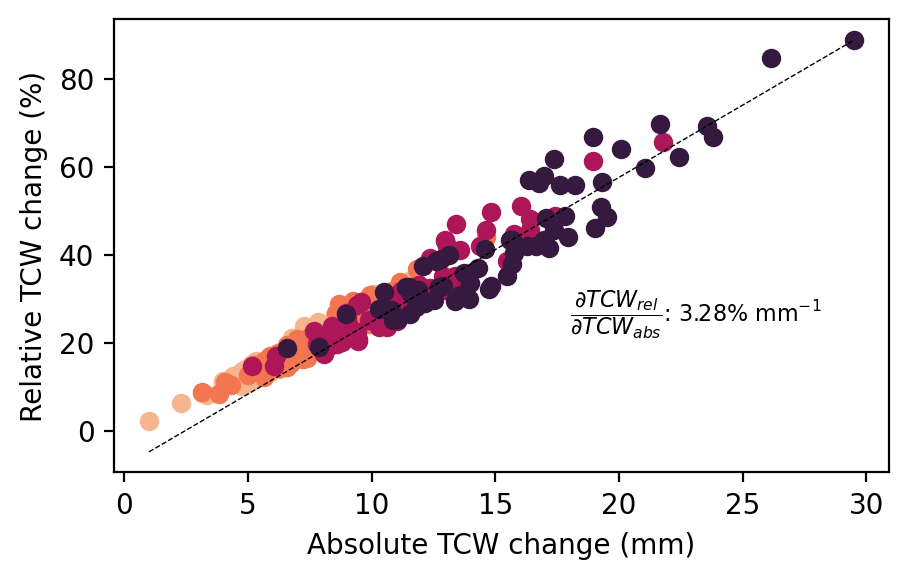

In [39]:
yy='2060'
f = plt.figure(figsize=(5,3), dpi=200)
testcolor = sns.color_palette("rocket")
post = [5,4,2,0]

ax = f.add_subplot(111)
allx=[]
ally=[]
for yids, ys in enumerate(['2030', '2040', '2060', '2080']):


    x = cmip_read[ys]['tcw_mean']
    x = x[np.isfinite(x)]
    y = (cmip_read[ys]['tcw_mean']/((cmip_read[ys])['tcw_hist'])*100)
    y = y[np.isfinite(y)]



    plt.scatter(x, y, c=testcolor[post[yids]])
    
    allx.extend(x.values)
    ally.extend(y.values)

plt.ylabel('Relative TCW change (%)')
plt.xlabel('Absolute TCW change (mm)')





#cslope, sintercept, cr, cpval, cstd = stats.linregress(allx, ally  )

plt.plot(np.linspace(np.min(allx), np.max(allx),10), sintercept + cslope * np.linspace(np.min(allx), np.max(allx),10), linestyle='dashed', linewidth=0.5, color='k')
plt.text(18,25, r'$\dfrac{\partial TCW_{rel}}{\partial TCW_{abs}}$: ' + str(np.round(cslope,2)) +r'% mm$^{-1}$', fontsize=8)


In [40]:
thist = np.arange(20,70,0.25)
thist2 = np.arange(20,70,0.25)
np.random.shuffle(thist)

In [41]:
add = np.linspace(20,60,len(thist))
np.random.shuffle(add)
tfut = thist+add
np.random.shuffle(tfut)

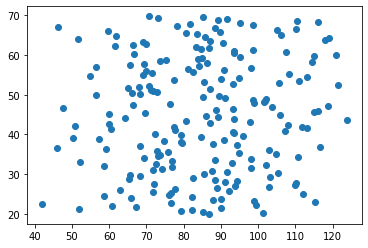

In [42]:
plt.scatter(tfut,thist)

Text(25, 25, '$\\dfrac{\\partial TCW_{rel}}{\\partial TCW_{abs}}$: 3.49% mm$^{-1}$')

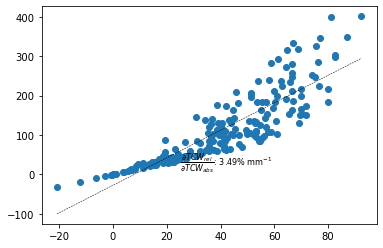

In [43]:
plt.scatter(tfut-thist,(tfut-thist)/thist*100)


tslope, tintercept, tr, tpval, tstd = stats.linregress(tfut-thist, (tfut-thist)/thist*100  )

plt.plot(np.linspace(np.min(tfut-thist), np.max(tfut-thist),10), tintercept + tslope * np.linspace(np.min(tfut-thist), np.max(tfut-thist),10), linestyle='dashed', linewidth=0.5, color='k')
plt.text(25,25, r'$\dfrac{\partial TCW_{rel}}{\partial TCW_{abs}}$: ' + str(np.round(tslope,2)) +r'% mm$^{-1}$', fontsize=8)

Text(25, 25, '$\\dfrac{\\partial TCW_{rel}}{\\partial TCW_{abs}}$: 3.49% mm$^{-1}$')

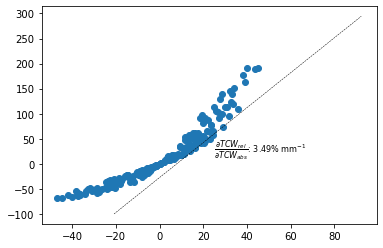

In [44]:
plt.scatter(thist-thist2,(thist-thist2)/thist2*100)


tslope, tintercept, tr, tpval, tstd = stats.linregress(tfut-thist, (tfut-thist)/thist*100  )

plt.plot(np.linspace(np.min(tfut-thist), np.max(tfut-thist),10), tintercept + tslope * np.linspace(np.min(tfut-thist), np.max(tfut-thist),10), linestyle='dashed', linewidth=0.5, color='k')
plt.text(25,25, r'$\dfrac{\partial TCW_{rel}}{\partial TCW_{abs}}$: ' + str(np.round(tslope,2)) +r'% mm$^{-1}$', fontsize=8)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(18, 25, '$\\dfrac{\\partial TCW_{rel}}{\\partial TCW_{abs}}$: 2.89% mm$^{-1}$')

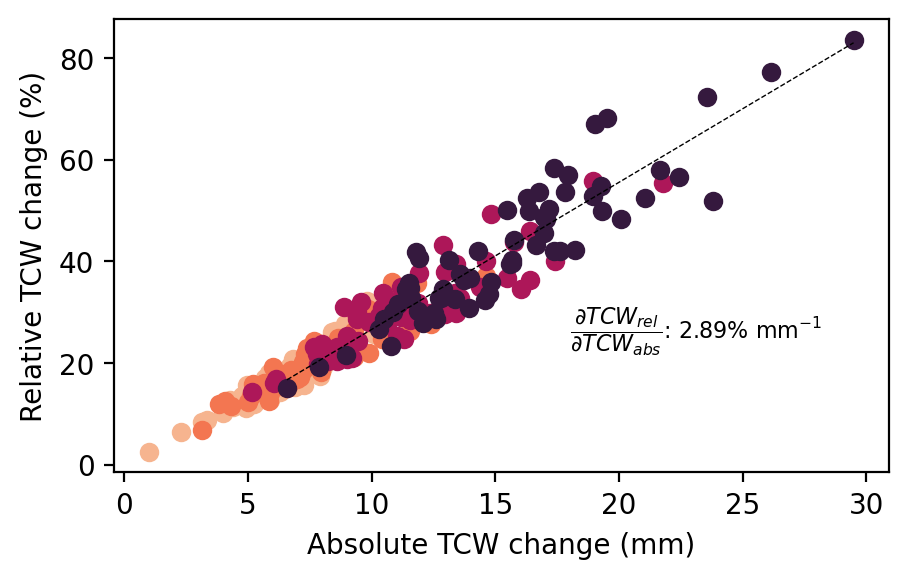

In [46]:
yy='2060'
f = plt.figure(figsize=(5,3), dpi=200)
testcolor = sns.color_palette("rocket")
post = [5,4,2,0]

ax = f.add_subplot(111)
allx=[]
ally=[]
for yids, ys in enumerate(['2030', '2040', '2060', '2080']):


    x = cmip_read[ys]['tcw_mean'].values
    np.random.shuffle(x)
    
    y = cmip_read[ys]['tcw_hist'].values
    np.random.shuffle(y)

    y = x/y*100
    



    plt.scatter(x, y, c=testcolor[post[yids]])

plt.ylabel('Relative TCW change (%)')
plt.xlabel('Absolute TCW change (mm)')



allx = x
ally = y

cslope, sintercept, cr, cpval, cstd = stats.linregress(allx, ally  )

plt.plot(np.linspace(np.min(allx), np.max(allx),10), sintercept + cslope * np.linspace(np.min(allx), np.max(allx),10), linestyle='dashed', linewidth=0.5, color='k')
plt.text(18,25, r'$\dfrac{\partial TCW_{rel}}{\partial TCW_{abs}}$: ' + str(np.round(cslope,2)) +r'% mm$^{-1}$', fontsize=8)

In [193]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 15)
fift = np.percentile(s,95)
print(fift)

48.257489733027725


In [194]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 100)
hund = np.percentile(s,95)
print(hund)

156.2275311344661


In [195]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 400)
fhund = np.percentile(s,95)
print(fhund)

108.16675766708869


In [203]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 10000)
tenthous = np.percentile(s,95)
print(tenthous)

101.8550143576618


(array([7.564e+03, 1.624e+03, 4.530e+02, 1.760e+02, 8.900e+01, 3.600e+01,
        2.300e+01, 1.000e+01, 9.000e+00, 5.000e+00]),
 array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360., 400.]),
 <BarContainer object of 10 artists>)

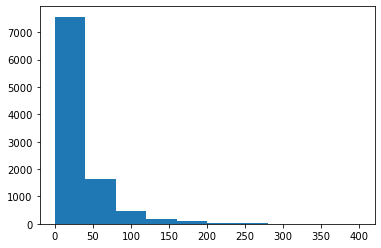

In [197]:
plt.hist(np.random.lognormal(mu, sigma, 10000), range=[0,400])

In [231]:
diffs = []
mu, sigma = 3., 1. # mean and standard deviation
for i in range(10000):
    s = np.random.lognormal(mu, sigma, 700)
    tenthous = np.percentile(s,95)
    
    s = np.random.lognormal(mu, sigma, 400)
    fhund = np.percentile(s,95)

    diffs.append((tenthous-fhund)/tenthous)

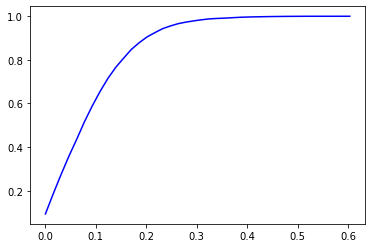

In [232]:
# evaluate the histogram
values, base = np.histogram(np.abs(diffs), bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values/np.sum(values))
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

In [181]:
(tenthous-np.percentile(np.random.random(400)*100,95))/tenthous

-0.008974676987230255

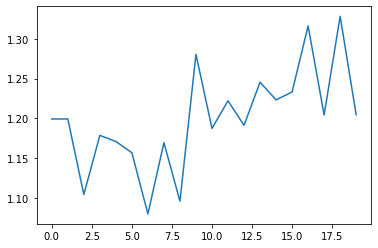

In [101]:
plt.plot(tcwvfac_all)

In [46]:
np.median(tcwvfac_all)

1.1993875805028695

In [47]:
len(tcwvfac_all)

20

In [48]:
domain = [-10,15,9,19]
def calc_mcs_stuff(dic, domain):
    m1=7
    m2=9
    #ipdb.set_trace()
    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    
    return dicout

In [49]:
def calc_mcs(domain):

    obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
    cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
    cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

    obs_mcs95 = calc_mcs_stuff(obs_mcs_d, domain).quantile(0.95)
    cp4hist_mcs95 = calc_mcs_stuff(cp4hist_mcs_d, domain).quantile(0.95)
    cp4fut_mcs95 = calc_mcs_stuff(cp4fut_mcs_d, domain).quantile(0.95)
    
    return cp4hist_mcs95, cp4fut_mcs95, obs_mcs95

10,90 perc tcw model UKESM1-0-LL bcc-csm1-1
Shear 10,90 0.24814885631467257 1.8190782773258227
TCW 10, 90 2040 6.675182114379948 15.206813804114274
TCW_abs 10, 90 [ 5.02517983 11.44792347]
10,90 perc tcw model FGOALS-g2 CMCC-CM
Shear 10,90 0.1259664248284747 2.3088007431416995
TCW 10, 90 2060 11.681530971641402 23.097283130278697
TCW_abs 10, 90 [ 8.7940363  17.38799022]
10,90 perc tcw model MPI-ESM1-2-HR IPSL-CM5A-MR
Shear 10,90 0.13169107902101823 2.3747777893280784
TCW 10, 90 2080 14.855335244384 31.35422190769743
TCW_abs 10, 90 [11.183325   23.60394081]
CP4_domainmean [41.307987]
Cp4_perc_delta [0.50279625]
mean 1.1996745900023602 40.419306877753776 [2.33851865] [0.05785648]
CP4_domainmean [41.307987]
Cp4_perc_delta [0.50279625]
min 1.0801933784407936 32.36138490331091 [2.33851865] [0.07226263]
CP4_domainmean [41.307987]
Cp4_perc_delta [0.50279625]
max 1.328346912900901 46.05488524364704 [2.33851865] [0.05077678]


Text(0, 4, 'e')

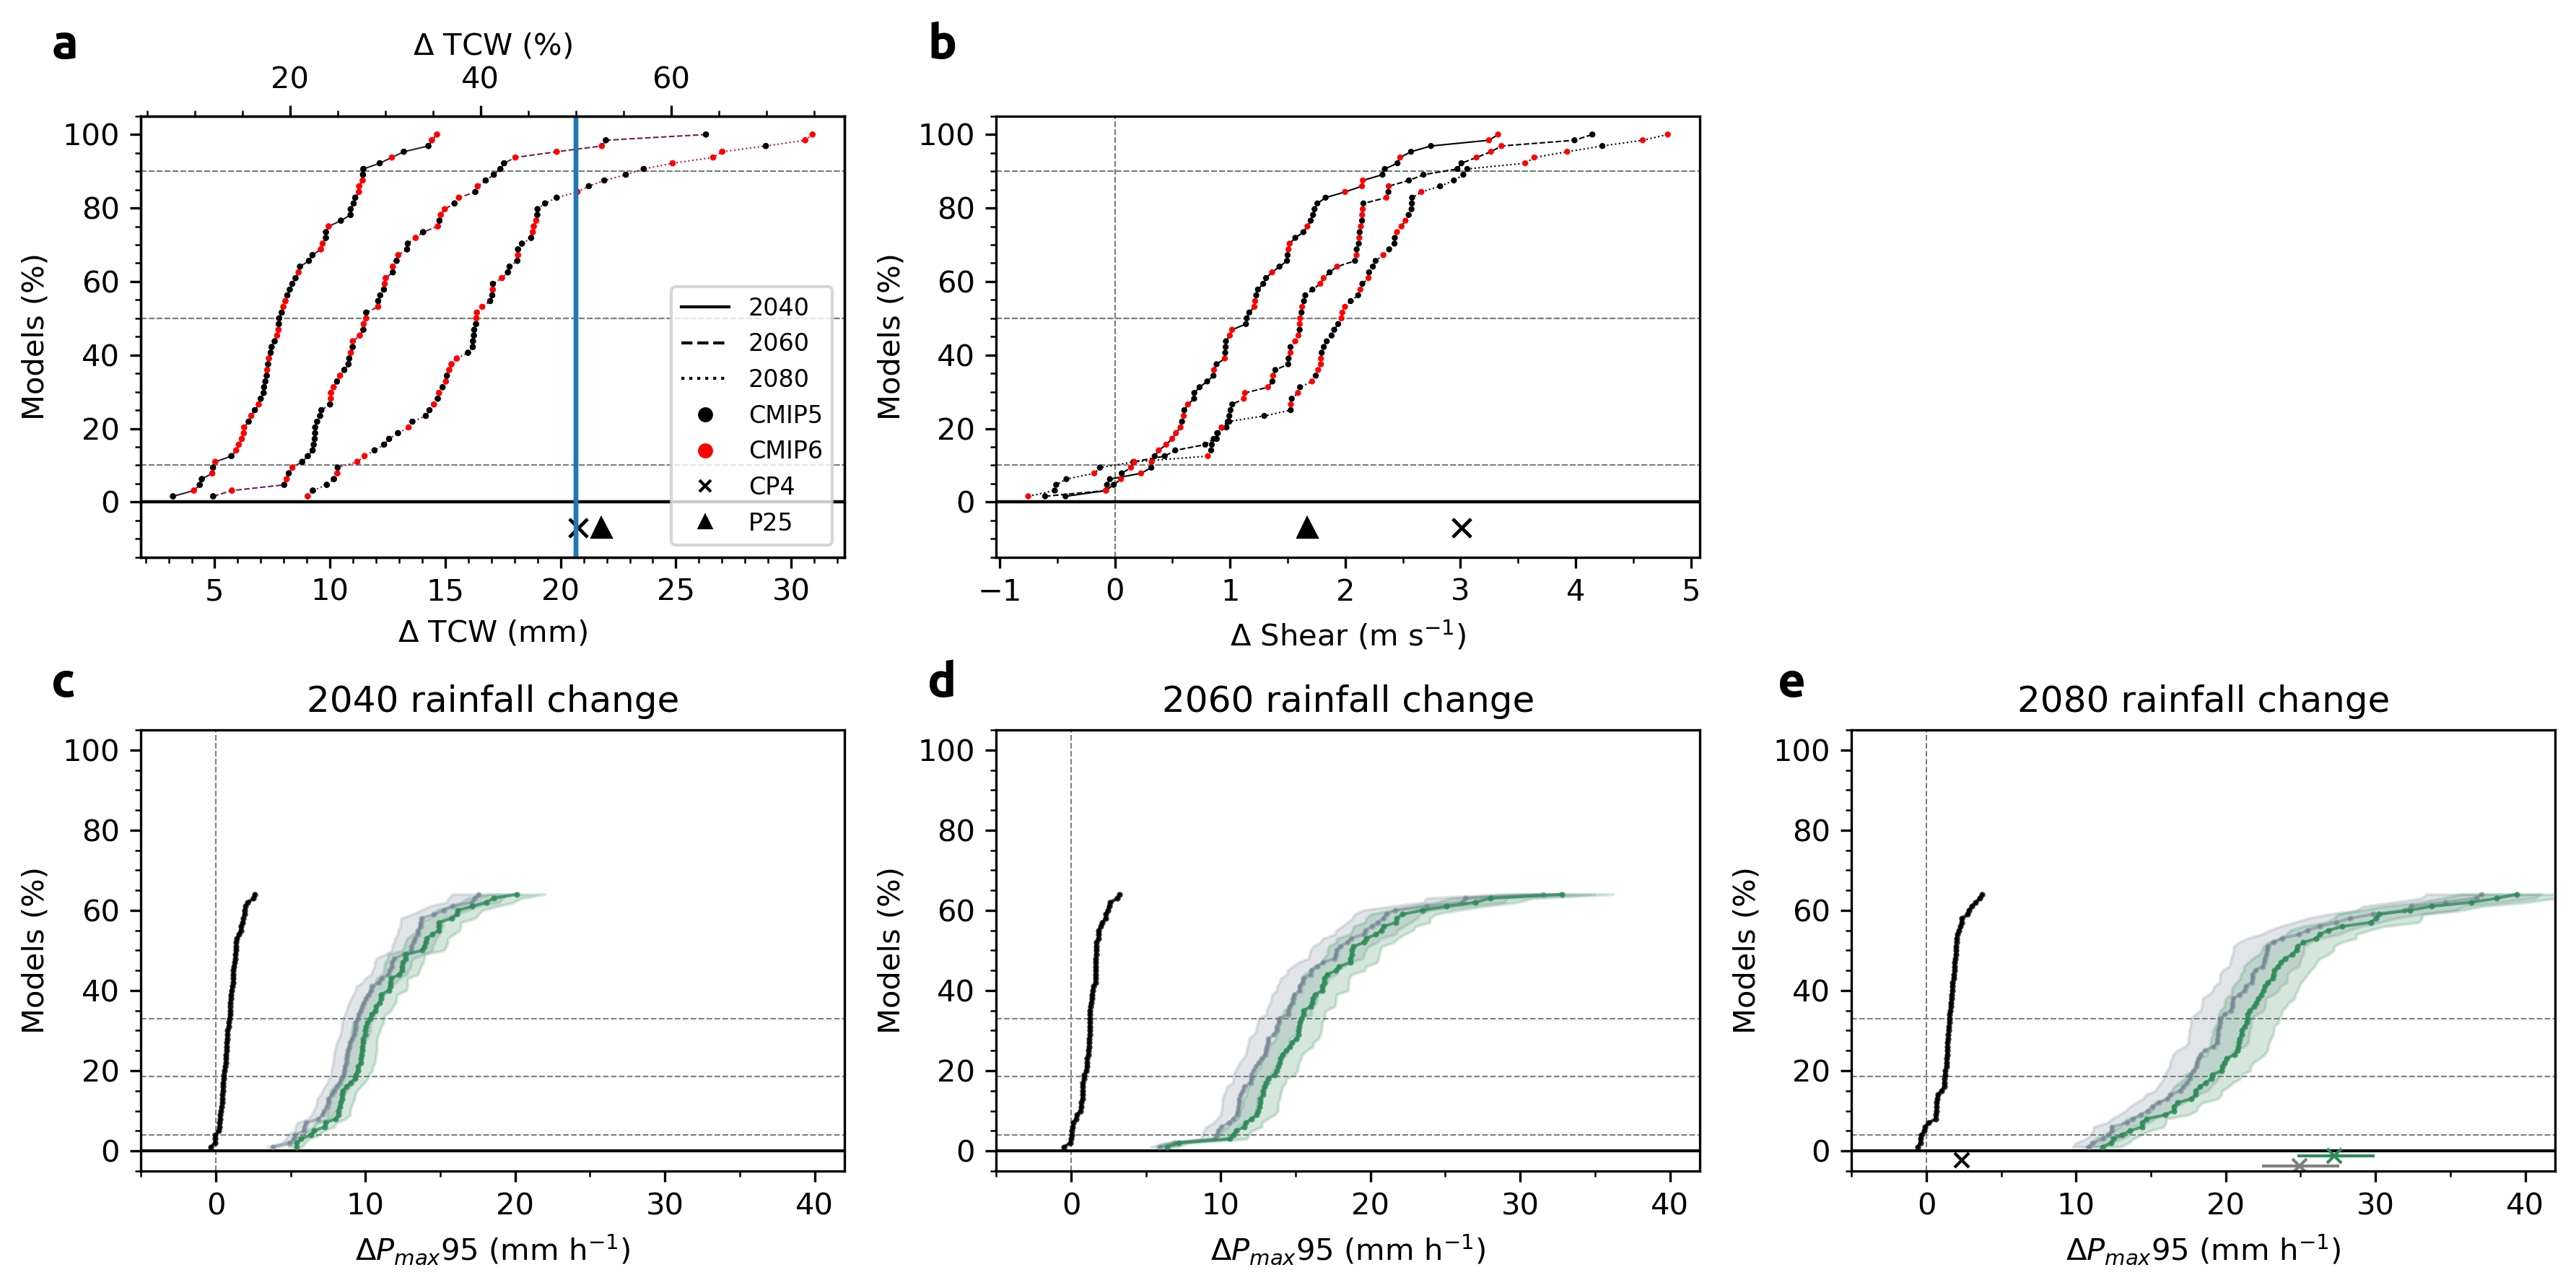

In [50]:
from matplotlib.lines import Line2D
#tcwvfac = tcwvfac_all[np.argmin(np.abs(cp4_historical_domainMean- ftcw['tcw_hist']))] #take tcw scaling for CP4 baseline tcw (37.2 mm domain wide) - it's the average scaling, where lower  
tcwvfac = np.mean(tcwvfac_all)

isclose = np.nanargmin(np.abs(cp4_df.loc['CP4hist', 'tcwv']-ftcw['tcw_hist']))
    
f = plt.figure(figsize=(12,6), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)
ax11 = ax1.twiny()
ax11.set_xlabel('$\Delta$ TCW (%)')

perc_dic = {}

cp4hist_mcs95, cp4fut_mcs95, obs_mcs95 = calc_mcs(domain)

testcolor = sns.color_palette("rocket")


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = ((cmip_read[stry])['tcw_mean'])/(cmip_read[stry])['tcw_hist'] 
    cmean = np.mean(x)
    cumulative_raw = np.sort(x)
    cumulative = cumulative_raw *cp4_historical_domainMean
    order = np.argsort(x)
    posimean = np.argmin(np.abs(cmean-cumulative))
    
    ccolours = colours[order]

    ax1.scatter(cumulative, (np.arange(len(cumulative))+1)/len(cumulative)*100, marker='o', s=1, c=ccolours, zorder=99)
    ax1.plot(cumulative, (np.arange(len(cumulative))+1)/len(cumulative)*100, linestyle=linestyle[ids], linewidth=0.5, color=testcolor[ids]) #color='k'
    
    ax11.scatter(cumulative_raw*100, (np.arange(len(cumulative))+1)/len(cumulative)*100, marker='o', s=1, color=ccolours)
    ax11.axvline(50)
    
 #   ipdb.set_trace()

    #ax1.set_title(r'Sahel-average TCW change')
    ax1.set_xlabel('$\Delta$ TCW (mm)')  #kg m$^{-2}$
    ax1.set_ylabel('Models (%)')


    x = (cmip_read[stry])['shear_mean']
    cumulative = np.sort(x)
    ccolours = colours[order]

    
    ax2.scatter(cumulative, (np.arange(len(cumulative))+1)/len(cumulative)*100, label=stry, marker='o', s=1, c=ccolours, zorder=99)
    ax2.plot(cumulative, (np.arange(len(cumulative))+1)/len(cumulative)*100,color='k', linestyle=linestyle[ids], linewidth=0.5)

    ax2.set_xlabel('$\Delta$ Shear (m s$^{-1}$)')
    ax2.set_ylabel('Models (%)')
    
    if ids == 2:

        ax1.plot(cp4_tcwv_diff*cp4_historical_domainMean,shiftfac, color='k', marker='x', label='CP4', linestyle='')
        ax2.plot(cp4_shear_diff,shiftfac, color='k', marker='x', label='CP4', linestyle='')
        
        ax1.plot(cp25_tcwv_diff*cp25_historical_domainMean,shiftfac, color='k', marker='^', label='P25', linestyle='')
        ax2.plot(cp25_shear_diff,shiftfac, color='k', marker='^', label='P25', linestyle='')

    else:
        
        shiftfac=-7
        ax1.plot(cp4_tcwv_diff*cp4_historical_domainMean,shiftfac, color='k', marker='x', linestyle='')
        ax2.plot(cp4_shear_diff,shiftfac, color='k', marker='x',  linestyle='')
        
        ax1.plot(cp25_tcwv_diff*cp25_historical_domainMean,shiftfac, color='k', marker='^', linestyle='')
        ax2.plot(cp25_shear_diff,shiftfac, color='k', marker='^',  linestyle='')
        
     #   ipdb.set_trace()
        
        
    ax1.axhline(90, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(10,linestyle='dashed', lw=0.5, color='grey', zorder=0)

    ax1.axhline(50, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axhline(90,linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(10,linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(50,linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax1.axhline(0, linestyle='solid', lw=1, color='k')
    ax2.axhline(0, linestyle='solid', lw=1, color='k')
    ax1.set_ylim(-15,105)
    ax2.set_ylim(-15,105)
    
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax11.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(5))
    
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(MultipleLocator(5))
    
    legend_elements = [Line2D([0], [0], color='k', lw=1, label='2040', linestyle='solid'),
                   Line2D([0], [0], color='k', lw=1, label='2060', linestyle='dashed'),
                   Line2D([0], [0], color='k', lw=1, label='2080', linestyle='dotted'),
                   Line2D([0], [0], marker='o', color='k', label='CMIP5',
                          markerfacecolor='k', markersize=4, linestyle=''),
                 Line2D([0], [0], marker='o', color='r', label='CMIP6',
                          markerfacecolor='r', markersize=4, linestyle=''),
                Line2D([0], [0], marker='x', color='k', label='CP4',
                          markerfacecolor='k', markersize=4, linestyle=''),
                Line2D([0], [0], marker='^', color='k', label='P25',
                          markerfacecolor='k', markersize=4, linestyle='')]

    
    ax1.legend(handles=legend_elements, loc='lower right', fontsize=8)
    
    
    #########################################
    ########################################
    #########################################
    
    ax = f.add_subplot(2,3,ids+4)
    ##########
    ax.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    fdic = {'min' : [], 'max' : [], 'mean':[]}
    
    for fag, tcwvfac in zip(['mean','min','max'],[np.mean(tcwvfac_all), np.min(tcwvfac_all), np.max(tcwvfac_all)]):
        
        if fag == 'mean':
            pcphist = np.mean(cp4_precip_hist)
        if fag == 'min':
            pcphist = np.min(cp4_precip_hist)
        if fag == 'max':
            pcphist = np.max(cp4_precip_hist)
        
        x = (cmip_read[stry])['tcw_mean']/(cmip_read[stry])['tcw_hist'] *cp4_historical_domainMean * tcwvfac  #/(cmip_read[stry])['tcw_hist']) * tcwvfac *100
        cumulative = np.sort(x)  # percentage rainfall increase from relative CMIP change

        order = np.argsort(x)
        mnames = (cmip_read['2040']).index[order]

            
        cmip_p_from_shear = (cmip_read[stry]).shear_mean[order] *shearfac  # absolute rainfall from CMIP shear change
        cmip_p_from_tcw = cumulative  # 
#         cmip_perc_per_mm = cumulative/cmip_p_from_tcw
#         cmip_perc_shear = cmip_p_from_shear * cmip_perc_per_mm

#         cmip_shear_ordered = np.sort(cmip_perc_shear)
#         cmip_total_ordered = np.sort(cumulative+cmip_perc_shear)

        cmip_shear_ordered = np.sort(cmip_p_from_shear)
        cmip_total_ordered = np.sort(cmip_p_from_tcw+cmip_p_from_shear)
        cumulative = cmip_p_from_tcw
        
        
        fdic[fag]=(cumulative,cmip_shear_ordered,cmip_total_ordered)

        
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90], interpolation='nearest'),0).astype(int)
    
    print('10,90 perc tcw model', mnames[perc[0]], mnames[perc[-1]])
    perc_dic[stry] = {'tcw': (mnames[perc[0]], mnames[perc[-1]])}
    
    print('Shear 10,90', cmip_shear_ordered[perc[0]], cmip_shear_ordered[perc[-1]])
    print('TCW 10, 90',stry,  cmip_p_from_tcw[perc[0]], cmip_p_from_tcw[perc[-1]])
    
    xs = (cmip_read[stry])['tcw_mean']/(cmip_read[stry])['tcw_hist'] *cp4_historical_domainMean  #/(cmip_read[stry])['tcw_hist']) * tcwvfac *100
    cum = np.sort(xs)  # percentage rainfall increase from relative CMIP change
    
    print('TCW_abs 10, 90', np.percentile(cum, [10,90], interpolation='nearest'))
    

    
    
    ax.plot(fdic['mean'][0], np.arange(len(fdic['mean'][0]))+1, color='slategrey', alpha=0.5, marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(fdic['mean'][0]))+1, fdic['min'][0], fdic['max'][0], color='slategrey', alpha=0.2, zorder=99)
    
    ax.plot(fdic['mean'][1], np.arange(len(fdic['mean'][0]))+1, color='k', alpha=0.8, marker='o', markersize=1, zorder=99, linewidth=1) 
    ax.fill_betweenx(np.arange(len(fdic['mean'][1]))+1, fdic['max'][1], fdic['min'][1], color='k', alpha=0.2, zorder=99)
    
    ax.plot(fdic['mean'][2], np.arange(len(fdic['mean'][0]))+1, color='seagreen', alpha=0.8, marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(fdic['mean'][2]))+1, fdic['min'][2], fdic['max'][2], color='seagreen', alpha=0.2, zorder=99)

    
    ax.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(5))

    
    ##############

    mst = 5
    if ids == 2:
        
        fdic4 = {'min' : [], 'max' : [], 'mean':[]}
        fdic25 = {'min' : [], 'max' : [], 'mean':[]}
        for fag, tcwvfac in zip(['mean','min','max'],[np.mean(tcwvfac_all), np.min(tcwvfac_all), np.max(tcwvfac_all)]):

            if fag == 'mean':
                pcphist = np.mean(cp4_precip_hist)

            if fag == 'min':
                pcphist = np.min(cp4_precip_hist)
            if fag == 'max':
                pcphist = np.max(cp4_precip_hist)

      
            cp4_perc_tcw = cp4_tcwv_diff *cp4_historical_domainMean * tcwvfac  #/cp4_historical_domainMean  #cp4_tcwv_diff
            cp4_p_from_shear = cp4_shear_diff *shearfac

            cp4_p_from_tcw = cp4_perc_tcw #cp4_perc_tcw * pcphist
            cp4_perc_per_mm = cp4_perc_tcw/cp4_p_from_tcw
            cp4_perc_shear = cp4_p_from_shear/ pcphist#* cp4_perc_per_mm


            print('CP4_domainmean', cp4_historical_domainMean)
            print('Cp4_perc_delta', cp4_tcwv_diff)
    #         cp25_perc_tcw = cp25_tcwv_diff * tcwvfac  # /cp4_historical_domainMean
    #         cp25_p_from_shear = cp25_shear_diff *shearfac
    #         cp25_p_from_tcw = cp25_perc_tcw *pcphist 
    #         cp25_perc_per_mm = cp25_perc_tcw/cp25_p_from_tcw
    #         cp25_perc_shear = cp25_p_from_shear * cp25_perc_per_mm


            print(fag, tcwvfac,pcphist, cp4_p_from_shear, cp4_perc_shear)

            fdic4[fag]=(cp4_p_from_tcw,cp4_p_from_shear,cp4_p_from_tcw+cp4_p_from_shear, tcwvfac, pcphist)

        shiftfac = 7
        ax.errorbar(fdic4['mean'][0],3.2-shiftfac,  xerr=[(fdic4['mean'][0]-fdic4['min'][0]), (fdic4['max'][0]-fdic4['mean'][0])],color='grey', marker='x', linewidth=1, ms=mst, label='CP4 TCW')
        ax.errorbar(fdic4['mean'][1],4.7-shiftfac,  xerr=[(fdic4['mean'][1]-fdic4['max'][1]), (fdic4['min'][1]-fdic4['mean'][1])],color='k', marker='x', linewidth=1, ms=mst, label='CP4 shear')
        ax.errorbar(fdic4['mean'][2],5.8-shiftfac,  xerr=[(fdic4['mean'][2]-fdic4['min'][2]), (fdic4['max'][2]-fdic4['mean'][2])],color='seagreen', marker='x', linewidth=1, ms=mst, label='CP4 TCW+shear')
   
    plt.xlabel('$\Delta P_{max}95}$ (mm h$^{-1}$)')
    plt.ylabel('Models (%)')
    ax.set_xlim(-5,42)
    ax.set_ylim(-5,105)

    plt.title(stry +' rainfall change')


plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.02, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.02, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.69, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel_inclCP4_ABS_hourlyScaling_relToCMIP_9-19N_20masked_0.1mm_CMIP6.jpg')

TCW_abs 10, 90 [ 5.2188859  10.90547943]
10,90 perc tcw model CIESM CMCC-CESM
TCW_precip 10, 90 [ 6.25946693 13.07989659]
shear_precip 10, 90 [0.24814886 1.81907828]
total_precip 10, 90 [ 7.19983102 13.67800634]
TCW_abs 10, 90 [ 7.97625075 15.76343802]
10,90 perc tcw model FGOALS-g2 MPI-ESM-LR
TCW_precip 10, 90 [ 9.56661609 18.90647178]
shear_precip 10, 90 [0.12596642 2.30880074]
total_precip 10, 90 [11.03226745 19.96807371]
TCW_abs 10, 90 [10.84703708 21.06571518]
10,90 perc tcw model AWI-CM-1-1-MR NorESM2-MM
TCW_precip 10, 90 [13.00980156 25.26595716]
shear_precip 10, 90 [0.13169108 2.37477779]
total_precip 10, 90 [15.00036334 26.86609698]


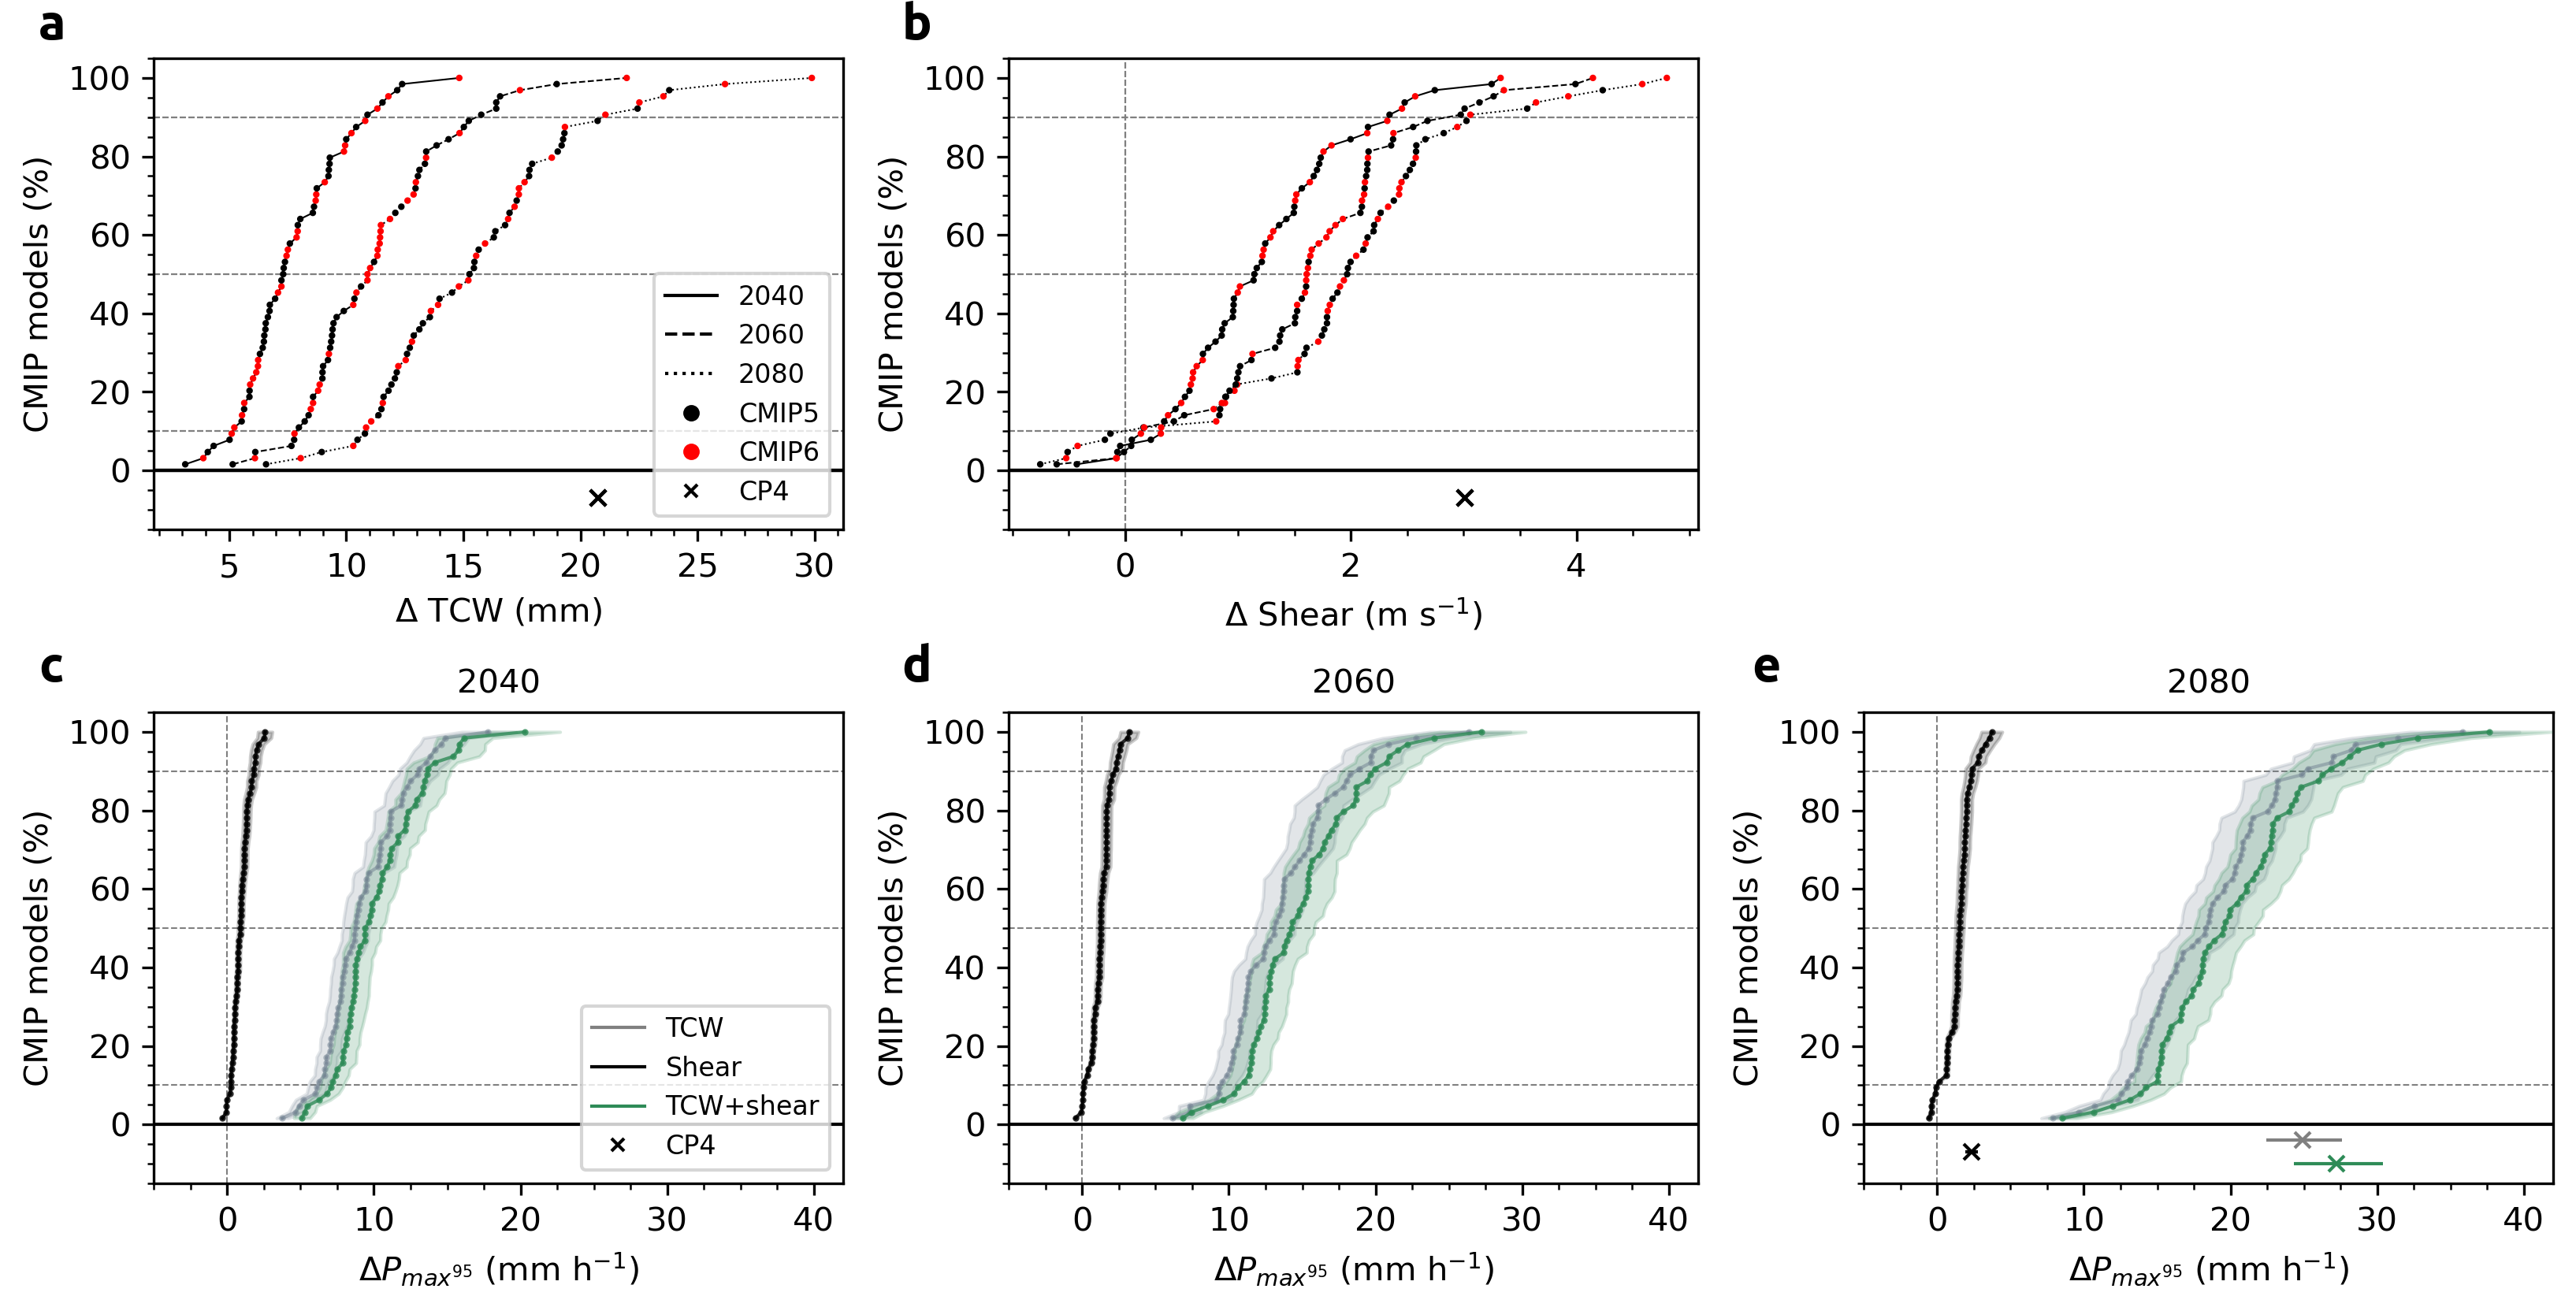

In [67]:
from matplotlib.lines import Line2D
#tcwvfac = tcwvfac_all[np.argmin(np.abs(cp4_historical_domainMean- ftcw['tcw_hist']))] #take tcw scaling for CP4 baseline tcw (37.2 mm domain wide) - it's the average scaling, where lower  
tcwvfac = np.mean(tcwvfac_all)

isclose = np.nanargmin(np.abs(cp4_df.loc['CP4hist', 'tcwv']-ftcw['tcw_hist']))
    
f = plt.figure(figsize=(11,5.5), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)
# ax11 = ax1.twiny()
# ax11.set_xlabel('$\Delta$ TCW (%)')

perc_dic = {}

cp4hist_mcs95, cp4fut_mcs95, obs_mcs95 = calc_mcs(domain)

testcolor = sns.color_palette("rocket")


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = ((cmip_read[stry])['tcw_mean'])#/(cmip_read[stry])['tcw_hist'] 
    cmean = np.mean(x)
    cumulative_raw = np.sort(x)
    cumulative = cumulative_raw #*cp4_historical_domainMean
    order = np.argsort(x)
    posimean = np.argmin(np.abs(cmean-cumulative))
    
    ccolours = colours[order]

    ax1.scatter(cumulative, (np.arange(len(cumulative))+1)/len(cumulative)*100, marker='o', s=1, c=ccolours, zorder=99)
    ax1.plot(cumulative, (np.arange(len(cumulative))+1)/len(cumulative)*100, linestyle=linestyle[ids], linewidth=0.5, color='k') #color='k'
    
#     ax11.scatter(cumulative*cslope, (np.arange(len(cumulative))+1)/len(cumulative)*100, marker='o', s=1, color=ccolours)
#     ax11.spines['top'].set_color('grey')
#     ax11.tick_params(axis='x', colors='grey', which='both')
#     ax11.xaxis.label.set_color('grey')
#     ax11.xaxis.label.set_color('grey')
 #   ax11.axvline(50)
    
 #   ipdb.set_trace()

    #ax1.set_title(r'Sahel-average TCW change')
    ax1.set_xlabel('$\Delta$ TCW (mm)')  #kg m$^{-2}$
    ax1.set_ylabel('CMIP models (%)')
    
    print('TCW_abs 10, 90', np.percentile(cumulative, [10,90], interpolation='nearest'))


    x = (cmip_read[stry])['shear_mean']
    cumulative = np.sort(x)
    ccolours = colours[order]

    
    ax2.scatter(cumulative, (np.arange(len(cumulative))+1)/len(cumulative)*100, label=stry, marker='o', s=1, c=ccolours, zorder=99)
    ax2.plot(cumulative, (np.arange(len(cumulative))+1)/len(cumulative)*100,color='k', linestyle=linestyle[ids], linewidth=0.5)

    ax2.set_xlabel('$\Delta$ Shear (m s$^{-1}$)')
    ax2.set_ylabel('CMIP models (%)')
    msi = 5
    if ids == 2:

        ax1.plot(cp4_tcwv_diff*cp4_historical_domainMean,shiftfac, color='k', marker='x', label='CP4', linestyle='', markersize=msi)
        ax2.plot(cp4_shear_diff,shiftfac, color='k', marker='x', label='CP4', linestyle='', markersize=msi)
        
#         ax1.plot(cp25_tcwv_diff*cp25_historical_domainMean,shiftfac, color='k', marker='^', label='P25', linestyle='', markersize=msi)
#         ax2.plot(cp25_shear_diff,shiftfac, color='k', marker='^', label='P25', linestyle='',markersize=msi)

    else:
        
        shiftfac=-7
        ax1.plot(cp4_tcwv_diff*cp4_historical_domainMean,shiftfac, color='k', marker='x', linestyle='', markersize=msi)
        ax2.plot(cp4_shear_diff,shiftfac, color='k', marker='x',  linestyle='', markersize=msi)
        
#         ax1.plot(cp25_tcwv_diff*cp25_historical_domainMean,shiftfac, color='k', marker='^', linestyle='', markersize=msi)
#         ax2.plot(cp25_shear_diff,shiftfac, color='k', marker='^',  linestyle='', markersize=msi)
        
     #   ipdb.set_trace()
        
        
    ax1.axhline(90, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(10,linestyle='dashed', lw=0.5, color='grey', zorder=0)

    ax1.axhline(50, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axhline(90,linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(10,linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(50,linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax1.axhline(0, linestyle='solid', lw=1, color='k')
    ax2.axhline(0, linestyle='solid', lw=1, color='k')
    ax1.set_ylim(-15,105)
    ax2.set_ylim(-15,105)
    
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax11.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(5))
    
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(MultipleLocator(5))
    
    legend_elements = [Line2D([0], [0], color='k', lw=1, label='2040', linestyle='solid'),
                   Line2D([0], [0], color='k', lw=1, label='2060', linestyle='dashed'),
                   Line2D([0], [0], color='k', lw=1, label='2080', linestyle='dotted'),
                   Line2D([0], [0], marker='o', color='k', label='CMIP5',
                          markerfacecolor='k', markersize=4, linestyle=''),
                 Line2D([0], [0], marker='o', color='r', label='CMIP6',
                          markerfacecolor='r', markersize=4, linestyle=''),
                Line2D([0], [0], marker='x', color='k', label='CP4',
                          markerfacecolor='k', markersize=4, linestyle='')]
#                 Line2D([0], [0], marker='^', color='k', label='P25',
#                           markerfacecolor='k', markersize=4, linestyle='')]

    
    ax1.legend(handles=legend_elements, loc='lower right', fontsize=8)
    
    
    #########################################
    ########################################
    #########################################
    
    ax = f.add_subplot(2,3,ids+4)
    ##########
    ax.axhline(10, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(50, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(90, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    #ax.axhline(100, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    fdic = {'min' : [], 'max' : [], 'mean':[]}
    
    for fag, tcwvfac in zip(['mean','min','max'],[np.median(tcwvfac_all), np.min(tcwvfac_all), np.max(tcwvfac_all)]):
        
        if fag == 'mean':
            sfac = shearfac
        if fag == 'min':
            sfac = shearfac-shearSE
        if fag == 'max':
            sfac = shearfac+shearSE
        
        x = (cmip_read[stry])['tcw_mean'] * tcwvfac  #/(cmip_read[stry])['tcw_hist']) * tcwvfac *100
        cumulative = np.sort(x)  # percentage rainfall increase from relative CMIP change

        order = np.argsort(x)
        mnames = (cmip_read['2040']).index[order]

            
        cmip_p_from_shear = (cmip_read[stry]).shear_mean[order] *sfac  # absolute rainfall from CMIP shear change
        cmip_p_from_tcw = cumulative  # 
#         cmip_perc_per_mm = cumulative/cmip_p_from_tcw
#         cmip_perc_shear = cmip_p_from_shear * cmip_perc_per_mm

#         cmip_shear_ordered = np.sort(cmip_perc_shear)
#         cmip_total_ordered = np.sort(cumulative+cmip_perc_shear)
     
        cmip_shear_ordered = np.sort(cmip_p_from_shear)
        cmip_total_ordered = np.sort(cmip_p_from_tcw+cmip_p_from_shear)
        cumulative = cmip_p_from_tcw
        
        
        fdic[fag]=(cumulative,cmip_shear_ordered,cmip_total_ordered)

        
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90], interpolation='nearest'),0).astype(int)
    
    print('10,90 perc tcw model', mnames[perc[0]], mnames[perc[-1]])
    perc_dic[stry] = {'tcw': (mnames[perc[0]], mnames[perc[-1]])}
    
#     print('precip_from_shear 10,90', cmip_shear_ordered[perc[0]], cmip_shear_ordered[perc[-1]])
#     print('precip_from_TCW 10, 90',stry,  cmip_p_from_tcw[perc[0]], cmip_p_from_tcw[perc[-1]])
    
    xs = (cmip_read[stry])['tcw_mean']/(cmip_read[stry])['tcw_hist'] *cp4_historical_domainMean  #/(cmip_read[stry])['tcw_hist']) * tcwvfac *100
    cum = np.sort(xs)  # percentage rainfall increase from relative CMIP change
    
    print('TCW_precip 10, 90', np.percentile(fdic['mean'][0], [10,90], interpolation='nearest'))
    print('shear_precip 10, 90', np.percentile(fdic['mean'][1], [10,90], interpolation='nearest'))
    print('total_precip 10, 90', np.percentile(fdic['mean'][2], [10,90], interpolation='nearest'))
    
    
    ax.plot(fdic['mean'][0],(np.arange(len(cumulative))+1)/len(cumulative)*100, color='slategrey', alpha=0.5, marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx((np.arange(len(cumulative))+1)/len(cumulative)*100, fdic['min'][0], fdic['max'][0], color='slategrey', alpha=0.2, zorder=99)
    
    ax.plot(fdic['mean'][1], (np.arange(len(cumulative))+1)/len(cumulative)*100, color='k', alpha=0.8, marker='o', markersize=1, zorder=99, linewidth=1) 
    ax.fill_betweenx((np.arange(len(cumulative))+1)/len(cumulative)*100, fdic['max'][1], fdic['min'][1], color='k', alpha=0.2, zorder=99)
    
    ax.plot(fdic['mean'][2], (np.arange(len(cumulative))+1)/len(cumulative)*100, color='seagreen', alpha=0.8, marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx((np.arange(len(cumulative))+1)/len(cumulative)*100, fdic['min'][2], fdic['max'][2], color='seagreen', alpha=0.2, zorder=99)

   # ipdb.set_trace()
    ax.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    
    ax.xaxis.set_minor_locator(MultipleLocator(2.5))
    ax.yaxis.set_minor_locator(MultipleLocator(5))

    
    ##############

    mst = 5
    if ids == 2:
        
        fdic4 = {'min' : [], 'max' : [], 'mean':[]}
        fdic25 = {'min' : [], 'max' : [], 'mean':[]}
        for fag, tcwvfac in zip(['mean','min','max'],[np.median(tcwvfac_all), np.min(tcwvfac_all), np.max(tcwvfac_all)]):

            if fag == 'mean':
                sfac = shearfac
            if fag == 'min':
                sfac = shearfac-shearSE
            if fag == 'max':
                sfac = shearfac+shearSE

      
            cp4_perc_tcw = cp4_tcwv_diff *cp4_historical_domainMean * tcwvfac  #/cp4_historical_domainMean  #cp4_tcwv_diff
            cp4_p_from_shear = cp4_shear_diff *sfac

            cp4_p_from_tcw = cp4_perc_tcw #cp4_perc_tcw * pcphist
            cp4_perc_per_mm = cp4_perc_tcw/cp4_p_from_tcw
            ##cp4_perc_shear = cp4_p_from_shear/ pcphist#* cp4_perc_per_mm

            cp25_perc_tcw = cp25_tcwv_diff * cp25_historical_domainMean * tcwvfac  # /cp4_historical_domainMean
            cp25_p_from_shear = cp25_shear_diff *sfac
            cp25_p_from_tcw = cp25_perc_tcw  
            cp25_perc_per_mm = cp25_perc_tcw/cp25_p_from_tcw
            #cp25_perc_shear = cp25_p_from_shear * cp25_perc_per_mm


            fdic4[fag]=(cp4_p_from_tcw,cp4_p_from_shear,cp4_p_from_tcw+cp4_p_from_shear, tcwvfac, pcphist)
            fdic25[fag]=(cp25_p_from_tcw,cp25_p_from_shear,cp25_p_from_tcw+cp25_p_from_shear, tcwvfac, pcphist)

        shiftfac = -7
        ax.errorbar(fdic4['mean'][0],shiftfac+3,  xerr=[(fdic4['mean'][0]-fdic4['min'][0]), (fdic4['max'][0]-fdic4['mean'][0])],color='grey', marker='x', linewidth=1, ms=mst, label='CP4 TCW')
        ax.errorbar(fdic4['mean'][1],shiftfac,  xerr=[(fdic4['mean'][1]-fdic4['max'][1]), (fdic4['min'][1]-fdic4['mean'][1])],color='k', marker='x', linewidth=1, ms=mst, label='CP4 shear')
        ax.errorbar(fdic4['mean'][2],shiftfac-3,  xerr=[(fdic4['mean'][2]-fdic4['min'][2]), (fdic4['max'][2]-fdic4['mean'][2])],color='seagreen', marker='x', linewidth=1, ms=mst, label='CP4 TCW+shear')
        
#         ax.errorbar(fdic25['mean'][0],shiftfac+3,  xerr=[(fdic25['mean'][0]-fdic25['min'][0]), (fdic25['max'][0]-fdic25['mean'][0])],color='grey', marker='^', linewidth=1, ms=mst, label='CP4 TCW')
#         ax.errorbar(fdic25['mean'][1],shiftfac,  xerr=[(fdic25['mean'][1]-fdic25['max'][1]), (fdic25['min'][1]-fdic25['mean'][1])],color='k', marker='^', linewidth=1, ms=mst, label='CP4 shear')
#         ax.errorbar(fdic25['mean'][2],shiftfac-3,  xerr=[(fdic25['mean'][2]-fdic25['min'][2]), (fdic25['max'][2]-fdic25['mean'][2])],color='seagreen', marker='^', linewidth=1, ms=mst, label='CP4 TCW+shear')
   
    plt.xlabel('$\Delta P_{max^{95}}}$ (mm h$^{-1}$)')
    plt.ylabel('CMIP models (%)')
    ax.set_xlim(-5,42)
    ax.set_ylim(-15,105)

    plt.title(stry , fontsize=10)
    
    if ids == 0:
        legend_elements = [Line2D([0], [0], color='grey', lw=1, label='TCW', linestyle='solid'),
                       Line2D([0], [0], color='k', lw=1, label='Shear', linestyle='solid'),
                       Line2D([0], [0], color='seagreen', lw=1, label='TCW+shear', linestyle='solid'),
                    Line2D([0], [0], marker='x', color='k', label='CP4',
                              markerfacecolor='k', markersize=4, linestyle='')]
#                     Line2D([0], [0], marker='^', color='k', label='P25',
#                               markerfacecolor='k', markersize=4, linestyle='')]


        ax.legend(handles=legend_elements, loc='lower right', fontsize=8)


plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e']
add = 0.02
plt.annotate(text[0], xy=(0.015, 0.94+add), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[1], xy=(0.35, 0.94+add), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.015, 0.45+add), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[3], xy=(0.35, 0.45+add), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[4], xy=(0.68, 0.45+add), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel_inclCP4_ABS_hourlyScaling_relToCMIP_9-19N_20masked_0.1mm_CMIP6.jpg')

In [220]:
(np.arange(65)+1)/65*100

array([  1.53846154,   3.07692308,   4.61538462,   6.15384615,
         7.69230769,   9.23076923,  10.76923077,  12.30769231,
        13.84615385,  15.38461538,  16.92307692,  18.46153846,
        20.        ,  21.53846154,  23.07692308,  24.61538462,
        26.15384615,  27.69230769,  29.23076923,  30.76923077,
        32.30769231,  33.84615385,  35.38461538,  36.92307692,
        38.46153846,  40.        ,  41.53846154,  43.07692308,
        44.61538462,  46.15384615,  47.69230769,  49.23076923,
        50.76923077,  52.30769231,  53.84615385,  55.38461538,
        56.92307692,  58.46153846,  60.        ,  61.53846154,
        63.07692308,  64.61538462,  66.15384615,  67.69230769,
        69.23076923,  70.76923077,  72.30769231,  73.84615385,
        75.38461538,  76.92307692,  78.46153846,  80.        ,
        81.53846154,  83.07692308,  84.61538462,  86.15384615,
        87.69230769,  89.23076923,  90.76923077,  92.30769231,
        93.84615385,  95.38461538,  96.92307692,  98.46

In [77]:
values = fdic['max'][2] * 2.4911090750810856

In [78]:
np.percentile(values, [10,90])

array([39.59202254, 73.30616584])

In [222]:
fdic['mean'][1]

array([-0.58361792, -0.40508642, -0.3954744 , -0.32664984, -0.13914082,
       -0.10084821,  0.13169108,  0.62661385,  0.64883235,  0.65360619,
        0.68693424,  0.69407387,  0.71852633,  0.76107143,  1.00683167,
        1.18507884,  1.18662954,  1.19211493,  1.23433908,  1.24779801,
        1.32888229,  1.35376943,  1.3702761 ,  1.38877743,  1.38879814,
        1.39373682,  1.40795107,  1.42745706,  1.46051924,  1.47828699,
        1.50490748,  1.52746576,  1.53274535,  1.5508949 ,  1.58962144,
        1.6396364 ,  1.65474244,  1.66783396,  1.70927203,  1.71325681,
        1.73865317,  1.75721456,  1.80942322,  1.84851438,  1.88437543,
        1.88669219,  1.90118071,  1.93177567,  1.95850536,  1.98015458,
        1.99911968,  2.00148897,  2.00335788,  2.06573116,  2.19189098,
        2.28458516,  2.34833867,  2.37477779,  2.76574338,  2.82668806,
        3.04844787,  3.28529952,  3.55751439,  3.72633301,         nan])

In [223]:
fdic['mean'][2]

array([ 9.27555996,  9.3334538 , 12.2898372 , 13.04979517, 13.21964472,
       13.51148433, 14.36343329, 14.5233817 , 14.65255116, 14.66243404,
       14.88390017, 14.99664716, 15.52264249, 15.58689269, 15.6831056 ,
       15.82046563, 15.881088  , 16.04272292, 16.43866696, 16.44228571,
       16.56797197, 16.63820628, 16.93346084, 17.3591645 , 17.36521121,
       17.93220909, 17.94710306, 18.12819241, 18.23211054, 18.93308547,
       19.32195746, 19.76226903, 20.06863701, 20.23150924, 20.36855282,
       20.53607202, 20.56110097, 20.95497538, 20.97236681, 21.04035908,
       22.28633988, 22.36398427, 22.37654307, 22.52128175, 22.64408993,
       22.96076562, 23.22960692, 23.32099542, 23.49116488, 23.7135262 ,
       24.12150259, 24.49667508, 24.53504288, 24.91093118, 25.10876014,
       26.24669715, 26.68077978, 26.75029022, 28.72495687, 28.98509781,
       30.61831077, 33.40368382, 39.40515618,         nan,         nan])